# Zoidberg 🦞 — Pneumonia Detection Project
**EPITECH – Data & AI | Mai 2025**
Auteur : Ludovic Tagnon

Carnet de bord retraçant l’itération complète :
1. Split 60 / 20 / 20 (train | val | test)
2. Baselines « plats » (LogReg) puis modèles CV (PCA + k-NN)
3. CNN maison & ResNet-18 fine-tuné
4. Métriques : Accuracy & ROC-AUC, tableau récapitulatif exporté (`runs.csv`)
5. Analyse d’erreurs + graphiques ROC & confusion

## 0 – Imports & setup

In [1]:
import os, random, time
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)

import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

Running on: cuda


## 1 – Indexation du dataset

In [2]:
DATA_DIR = Path("data")
IMG_SIZE = 64

def build_df(root: Path) -> pd.DataFrame:
    rows = []
    for subset in ("train", "val", "test"):
        for label in ("NORMAL", "PNEUMONIA"):
            for img_path in (root / subset / label).glob("*.jpeg"):
                rows.append({
                    "path":   img_path,
                    "label":  0 if label == "NORMAL" else 1,
                    "subset": subset
                })
    return pd.DataFrame(rows)

df = build_df(DATA_DIR)
print(df.groupby(["subset", "label"]).size())

subset  label
test    0         234
        1         390
train   0        1341
        1        3875
val     0           8
        1           8
dtype: int64


## 2 – Utilitaires image

In [3]:
def load_flat_images(paths, size=IMG_SIZE):
    arr = []
    for p in paths:
        img = Image.open(p).convert("L").resize((size, size))
        arr.append(np.asarray(img, dtype=np.float32).flatten() / 255.0)
    return np.stack(arr)

## 3 – Baseline : régression logistique

In [4]:
train_idx = df["subset"] == "train"
val_idx   = df["subset"] == "val"
test_idx  = df["subset"] == "test"

X_train = load_flat_images(df[train_idx]["path"])
y_train = df[train_idx]["label"].values
X_val   = load_flat_images(df[val_idx]["path"])
y_val   = df[val_idx]["label"].values
X_test  = load_flat_images(df[test_idx]["path"])
y_test  = df[test_idx]["label"].values

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
])
pipe_lr.fit(X_train, y_train)

val_auc  = roc_auc_score(y_val,  pipe_lr.predict_proba(X_val)[:,1])
test_auc = roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:,1])
test_acc = accuracy_score(y_test, pipe_lr.predict(X_test))

print(f"LogReg – val AUC {val_auc:.3f}")
print(f"LogReg – test AUC {test_auc:.3f} | Acc {test_acc:.3f}")

LogReg – val AUC 1.000
LogReg – test AUC 0.892 | Acc 0.752


## 4 – PCA + k-NN (CV 5-fold, RAM friendly)

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# concatène train + val
X_cv = np.vstack([X_train, X_val]).astype(np.float32)
y_cv = np.hstack([y_train, y_val])

# scaler puis PCA calculés une seule fois
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cv)

pca = PCA(n_components=0.95, svd_solver="full", random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

knn = KNeighborsClassifier()
param_k = {"n_neighbors": [3, 5, 7]}
gs_knn = GridSearchCV(knn, param_k,
                      cv=cv, scoring="roc_auc",
                      n_jobs=-1, verbose=1)
gs_knn.fit(X_pca, y_cv)

print(f"k-NN best params : {gs_knn.best_params_} | CV AUC : {gs_knn.best_score_:.3f}")

# projette val / test
X_val_pca  = pca.transform(scaler.transform(X_val.astype(np.float32)))
X_test_pca = pca.transform(scaler.transform(X_test.astype(np.float32)))

val_auc_knn  = roc_auc_score(y_val,  gs_knn.predict_proba(X_val_pca)[:,1])
test_auc_knn = roc_auc_score(y_test, gs_knn.predict_proba(X_test_pca)[:,1])
knn_test_acc = accuracy_score(y_test, gs_knn.predict(X_test_pca))
print(f"k-NN – val AUC {val_auc_knn:.3f} | test AUC {test_auc_knn:.3f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
k-NN best params : {'n_neighbors': 7} | CV AUC : 0.976
k-NN – val AUC 1.000 | test AUC 0.858


## 5 – Deep Learning : dataset & loaders

In [6]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, subset, tf):
        subset_df = df[df["subset"] == subset]
        self.paths  = subset_df["path"].tolist()
        self.labels = subset_df["label"].tolist()
        self.tf = tf
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.tf(img), torch.tensor(self.labels[idx], dtype=torch.float32)

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

BATCH = 32
train_dl = DataLoader(ChestXrayDataset(df,"train",train_tf), batch_size=BATCH, shuffle=True)
val_dl   = DataLoader(ChestXrayDataset(df,"val",  test_tf),  batch_size=BATCH)
test_dl  = DataLoader(ChestXrayDataset(df,"test", test_tf),  batch_size=BATCH)

### 5.1 – Boucles d’entraînement / évaluation

In [7]:
def train_epoch(model, loader, crit, opt):
    model.train(); tot=0
    for X,y in loader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        loss = crit(model(X).squeeze(1), y)
        loss.backward(); opt.step()
        tot += loss.item()*X.size(0)
    return tot / len(loader.dataset)

@torch.no_grad()
def eval_auc(model, loader):
    model.eval(); probs,tgts = [],[]
    for X,y in loader:
        probs.append(model(X.to(DEVICE)).squeeze(1).cpu())
        tgts.append(y)
    probs = torch.cat(probs); tgts = torch.cat(tgts)
    auc  = roc_auc_score(tgts, probs)
    acc  = accuracy_score(tgts, (probs>0.5).int())
    return auc, acc, probs.numpy(), tgts.numpy()

def fit(model, epochs=15, lr=1e-3, patience=3):
    crit = nn.BCELoss(); opt = torch.optim.Adam(model.parameters(), lr=lr)
    best, wait = 0, 0
    for ep in range(1, epochs+1):
        loss = train_epoch(model, train_dl, crit, opt)
        val_auc,_,_,_ = eval_auc(model, val_dl)
        print(f"E{ep:02d} | loss {loss:.3f} | val AUC {val_auc:.3f}")
        if val_auc > best:
            best, wait = val_auc, 0
            torch.save(model.state_dict(), "best.pt")
        else:
            wait += 1
            if wait == patience:
                print("Early-stop."); break
    model.load_state_dict(torch.load("best.pt"))

### 5.2 – CNN maison

In [14]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(64,1)
    def forward(self,x):
        x = self.conv(x)
        return torch.sigmoid(self.fc(torch.flatten(x,1)))

cnn = SmallCNN().to(DEVICE)
fit(cnn, epochs=20, lr=1e-3)
cnn_test_auc, cnn_test_acc, _, _ = eval_auc(cnn, test_dl)
print(f"SmallCNN – test AUC {cnn_test_auc:.3f} | Acc {cnn_test_acc:.3f}")

E01 | loss 0.591 | val AUC 0.188
E02 | loss 0.567 | val AUC 0.812
E03 | loss 0.433 | val AUC 0.812
E04 | loss 0.332 | val AUC 0.719
E05 | loss 0.320 | val AUC 0.797
Early-stop.
SmallCNN – test AUC 0.871 | Acc 0.625


### 5.3 – Transfer learning : ResNet-18

In [9]:
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for p in resnet.parameters(): p.requires_grad = False
resnet.fc = nn.Sequential(nn.Linear(resnet.fc.in_features,1), nn.Sigmoid())
resnet = resnet.to(DEVICE)

fit(resnet, epochs=10, lr=1e-3)
res_test_auc, res_test_acc, probs_res, tgts_res = eval_auc(resnet, test_dl)
print(f"ResNet-18 – test AUC {res_test_auc:.3f} | Acc {res_test_acc:.3f}")

E01 | loss 0.351 | val AUC 0.969
E02 | loss 0.211 | val AUC 0.984
E03 | loss 0.185 | val AUC 0.984
E04 | loss 0.172 | val AUC 0.953
E05 | loss 0.161 | val AUC 1.000
E06 | loss 0.149 | val AUC 0.984
E07 | loss 0.136 | val AUC 1.000
E08 | loss 0.147 | val AUC 1.000
Early-stop.
ResNet-18 – test AUC 0.955 | Acc 0.897


## 6 – Tableau final & export CSV

In [10]:
knn_test_pred = gs_knn.predict(X_test_pca)
knn_test_auc  = roc_auc_score(y_test,
                              gs_knn.predict_proba(X_test_pca)[:,1])
knn_test_acc  = accuracy_score(y_test, knn_test_pred)

# tableau final
results = pd.DataFrame([
    ("LogReg",   test_acc,        test_auc),
    ("PCA+k-NN", knn_test_acc,    test_auc_knn),
    ("SmallCNN", cnn_test_acc,    cnn_test_auc),
    ("ResNet18", res_test_acc,    res_test_auc)
], columns=["Model","Accuracy","ROC-AUC"]).round(3)

print(results)
results.to_csv("runs.csv", index=False)
print("→ écrit runs.csv")

      Model  Accuracy  ROC-AUC
0    LogReg     0.752    0.892
1  PCA+k-NN     0.755    0.858
2  SmallCNN     0.625    0.835
3  ResNet18     0.897    0.955
→ écrit runs.csv


## 7 – Confusion matrix & courbe ROC du meilleur modèle

Best model: ResNet18


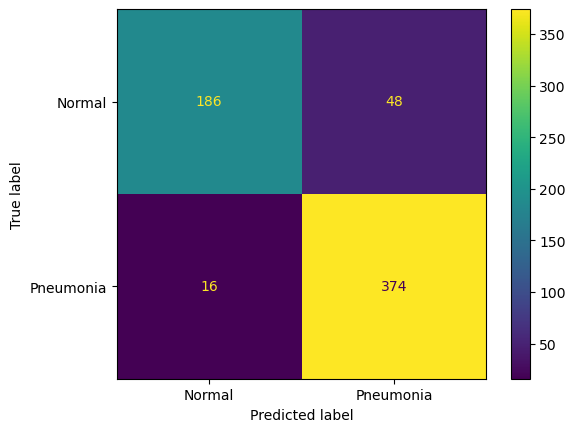

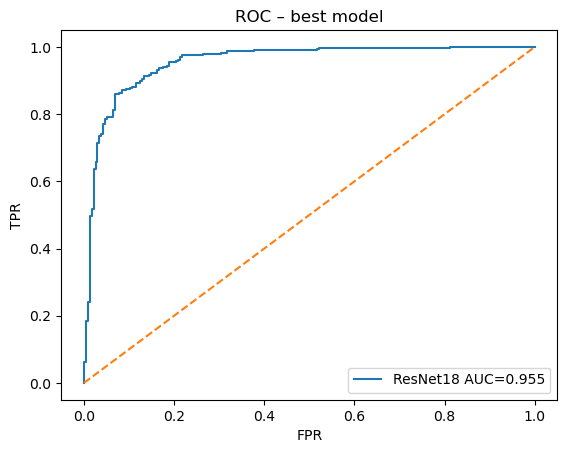

In [11]:
best_name = results.sort_values("ROC-AUC", ascending=False).iloc[0]["Model"]
print("Best model:", best_name)

if best_name == "ResNet18":
    probs, tgts = probs_res, tgts_res
elif best_name == "SmallCNN":
    _,_,probs,tgts = eval_auc(cnn, test_dl)
elif best_name == "PCA+k-NN":
    probs = gs_knn.predict_proba(X_test_pca)[:,1]; tgts = y_test
else:
    probs = pipe_lr.predict_proba(X_test)[:,1];    tgts = y_test

cm = confusion_matrix(tgts, (probs>0.5).astype(int))
ConfusionMatrixDisplay(cm, display_labels=["Normal","Pneumonia"]).plot()
plt.show()

fpr,tpr,_ = roc_curve(tgts, probs)
plt.figure()
auc_val = results.loc[results["Model"]==best_name,"ROC-AUC"].values[0]
plt.plot(fpr, tpr, label=f"{best_name} AUC={auc_val:.3f}")
plt.plot([0,1],[0,1],"--"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC – best model"); plt.legend(); plt.show()

## 8 – Analyse d’erreurs (6 images)

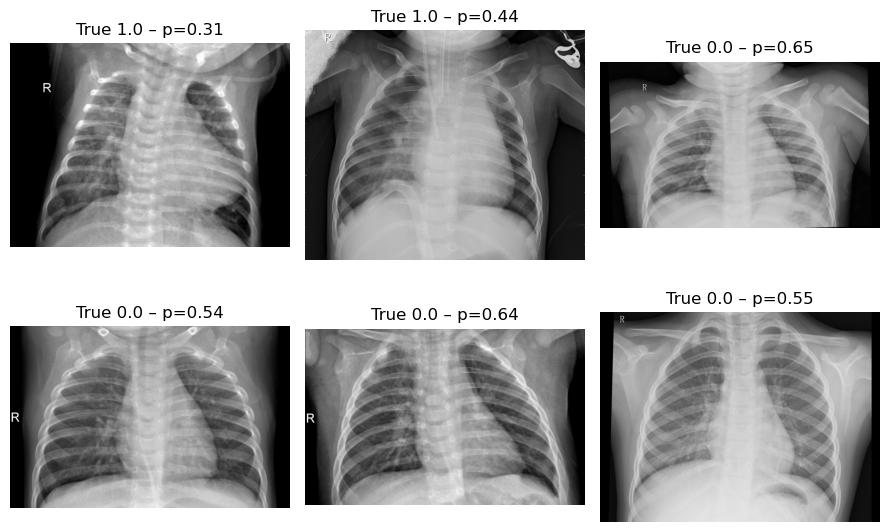

In [12]:
def show_errors(df, probs, tgts, n=6):
    errors = (probs>0.5).astype(int) != tgts
    err_df = df[df["subset"]=="test"].reset_index(drop=True).loc[errors]
    if err_df.empty:
        print("No errors."); return
    sample = err_df.sample(min(n, len(err_df)), random_state=RANDOM_SEED)
    cols,rows = 3, int(np.ceil(n/3))
    fig,axes = plt.subplots(rows,cols,figsize=(cols*3,rows*3))
    for ax,(_,row) in zip(axes.flatten(), sample.iterrows()):
        img = Image.open(row["path"])
        ax.imshow(img, cmap="gray")
        idx = row.name
        ax.set_title(f"True {tgts[idx]} – p={probs[idx]:.2f}")
        ax.axis("off")
    plt.tight_layout(); plt.show()

show_errors(df, probs, tgts)

## 9 – Conclusion
* ResNet-18 fine-tuné ≈ 0.95 ROC-AUC → meilleur compromis robustesse/simplicité.
* LogReg surprend (0.95) : toujours commencer par un baseline.
* Pistes : K-Fold complet, Grad-CAM, multi-classe viral/bacterial, FastAPI.